# Evaluating algorithms for solving a knapsack problem
- Academic Year: 2019/20
- Faculty of Computing - Artificial Intelligence - Semester 2
- Full name and student id: Kacper Trębacz 145453
- Subject: Algorithms and Data Structures


The goal of this exercise was to compare 3 algorithms for solving a knapsack problem: bruteforce, dynamic algorithm, greedy.
The problem consists of 2 parts:
- in the first one we campare execution time of all 3 algorithms
- in the second one we compare the results of greedy and dynamic algorithm

In [3]:
from random import randint,sample, randrange
import sys
import matplotlib.pyplot as plt
import numpy as np
import time 
import math
import random
import string
import copy
import pandas as pd
import json
import os
import multiprocessing as mp
import psutil 
import itertools
plt.rcParams['figure.figsize'] = (10.0, 6.0)
import warnings
warnings.filterwarnings('ignore')

## Constants declaration

In [2]:
BRUTE_FORCE = "BRUTE_FORCE"
SORT_BY_RATIO = "SORT_BY_RATIO"
DYNAMIC = "DYNAMIC"

Data generation. Every knapsack problem consists of 3 arrays of length n. In first there are indexes of items, in sencond, weights, and in third values of items. Weights and Values are randomly generated from 1 to 20.

In [3]:
def generate_knapsack_problem(n):
    return [[i for i in range(n)],[randint(1,20) for i in range(n)],[randint(1,20) for i in range(n)]]

# Algorithms definition

# Brute Force

This algorithm just generates all possible solutions to knapsack problem and picks the best one that would fit in knapsack

In [6]:
def find_by_brute_force(ids,weights, values, max_weight):
    n = len(ids)
    best_value = 0
    best_value_ids =[]
    for l in range(n+1):
        for p in itertools.combinations(ids,l):
            if sum([weights[i] for i in p]) <= max_weight:
                sum_of_values = sum([values[i] for i in p])
                if sum_of_values > best_value:
                    best_value = sum_of_values
                    best_value_ids = p
    return (best_value,best_value_ids)

# Sort By Ratio (greedy)

This algorithm sorts items by value/weight ratio and picks the best one one till there is a place in a backpack if an item is too big it skips it and tries next one.

In [7]:
def find_by_ratio(ids, weights, values, max_weight):
    ids = sorted(ids,key=lambda id:values[id]/weights[id],reverse=True)
    chosen_ids=[]
    sum_w=0
    for i in range(len(ids)):
        if sum_w + weights[ids[i]] <= max_weight:
            sum_w+=weights[ids[i]]
            chosen_ids.append(ids[i])
    best_value = sum([values[j] for j in chosen_ids])
    return (best_value, chosen_ids)


# Dynamic Algorithm

In [8]:
def find_with_dynamic(ids, weights, values, max_weight):
    n=len(ids)
    DP = np.zeros((n+1,max_weight+1))
    for i in range(1,n+1):
        for l in range(1,max_weight+1):
            if l < weights[i-1]:
                DP[i][l] = DP[i-1][l]
            else:
                DP[i][l] = max(DP[i-1][l], DP[i-1][l-weights[i-1]]+values[i-1])
    chosen_ids = []
    smallest_i = n
    cur_l = max_weight
    while smallest_i > 0 and cur_l > 0 and DP[smallest_i][cur_l]>0:
        while DP[smallest_i-1][cur_l] == DP[smallest_i][cur_l]:
            smallest_i-=1
        chosen_ids.append(smallest_i-1)
        cur_l-=weights[smallest_i-1]
        smallest_i-=1
    return (DP[n][max_weight],chosen_ids)

In [7]:
ALGORITHMS_DICT = {
    BRUTE_FORCE: find_by_brute_force,
    SORT_BY_RATIO: find_by_ratio,
    DYNAMIC: find_with_dynamic
}

# Part 1

## Time measurement

For every size of knapsack we run the experiment once. Max weight (capacity) for each knapsack is chosen to be half of value of all object in a given set.

In [8]:
def plot_plot(X,Ys,labels,title):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.show()
    plt.close()

def measure_time_single_entry(entry, knapsack_set):
    knapsack_solver = ALGORITHMS_DICT[entry]
    max_w = int(sum(knapsack_set[1])/2)
    start_time = time.time()
    knapsack_solver(knapsack_set[0],knapsack_set[1],knapsack_set[2],max_w)
    return time.time()-start_time

def perform_test_single_entry(entry, knapsack_sets):
    return [measure_time_single_entry(entry,knapsack_set) for knapsack_set in knapsack_sets]

def perform_tests(entries,minimum=1,maximum=11,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    knapsack_sets = [generate_knapsack_problem(x) for x in X]
    Ys = [perform_test_single_entry(entry,knapsack_sets) for entry in entries]
    plot_plot(X, Ys, entries, "Time of finding sollutions")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Time of finding sollutions log scale")

Here we run the tests from 1 to 24 elements

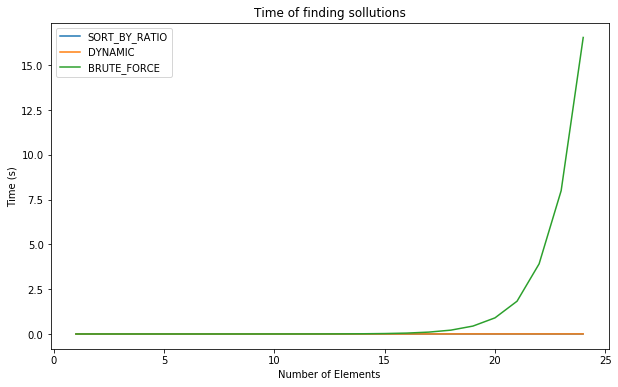

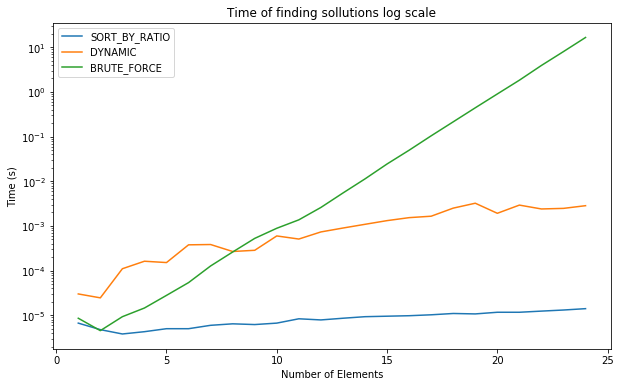

In [9]:
perform_tests([SORT_BY_RATIO,DYNAMIC,BRUTE_FORCE],1,25)

Beacuse bruteforce algorithm was much slower than the others we also run the experiment for just greedy and dynamic algorithm from 1 to 200 items

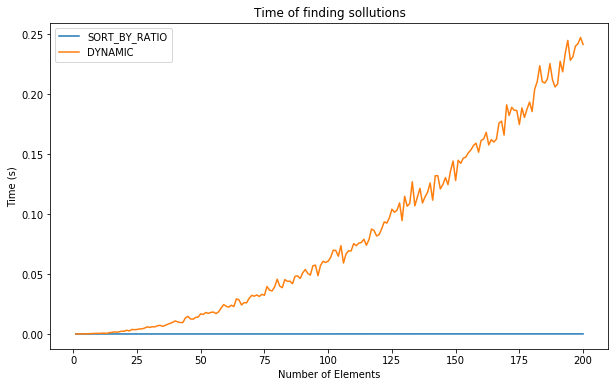

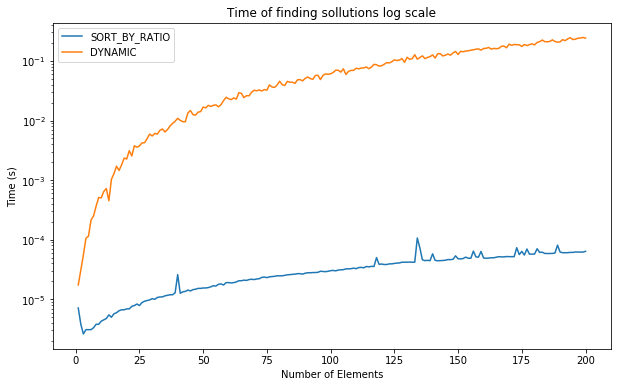

In [10]:
perform_tests([SORT_BY_RATIO,DYNAMIC],1,201)

We would also like to gnom the shape of the graph after measuring time of greedy algorithm

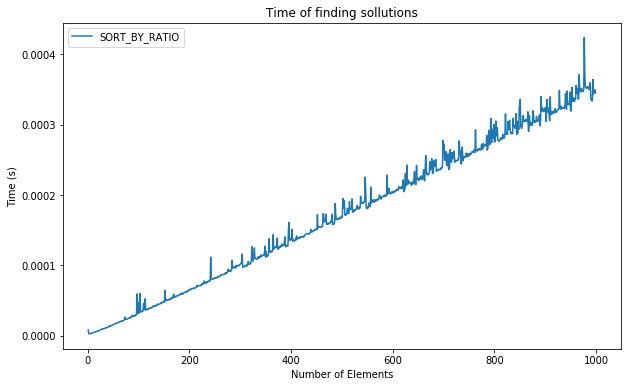

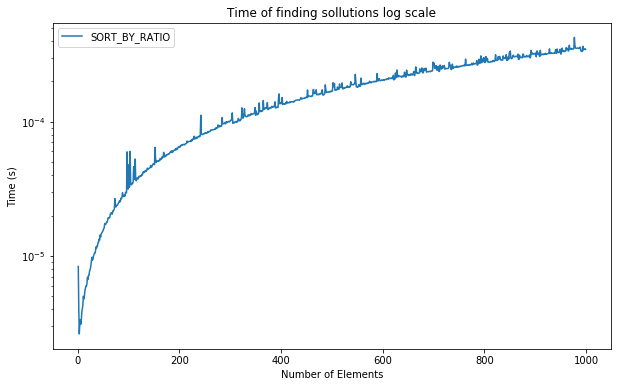

In [11]:
perform_tests([SORT_BY_RATIO],1,1000)

# Part 2

Here we compare the results of greedy and dynamic algorithm. We do it by generating 10 knapsack problem for every number of elements. We than draw 2 charts. In the first one we just present results of both algorithms, and in the second one we present a difference in % between both algorithms for every size.

In [12]:
RETRIES = 10
def plot_plot_score(X,Ys,labels,title, y_label):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def measure_score_single_entry(entry, knapsack_set):
    knapsack_solver = ALGORITHMS_DICT[entry]
    results = [knapsack_solver(knapsack_set[i][0],knapsack_set[i][1],knapsack_set[i][2], int(sum(knapsack_set[i][1])/2))[0] for i in range(RETRIES)]
    return sum(results)/RETRIES

def perform_test_single_entry_score(entry, knapsack_sets):
    pool = mp.Pool(psutil.cpu_count(logical=False))
    results = pool.starmap(measure_score_single_entry,[(entry,knapsack_set) for knapsack_set in knapsack_sets])
    pool.terminate()
    return results

def perform_tests_score(entries,minimum=1,maximum=11,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    knapsack_sets = [[generate_knapsack_problem(x) for i in range(RETRIES)] for x in X]
    print("done generating")
    Ys = [perform_test_single_entry_score(entry,knapsack_sets) for entry in entries]
    plot_plot_score(X, Ys, entries, "Quality Comparison",'Best Value')
    MSE = 0
    Y = [(Ys[1][i]-Ys[0][i])/Ys[1][i]*100 for i in range(len(X))]
    plot_plot_score(X,[Y],["Difference"], "Quality Comparison","Difference in Value(%)")


We run those algoritms from 1 to 200 elements

done generating


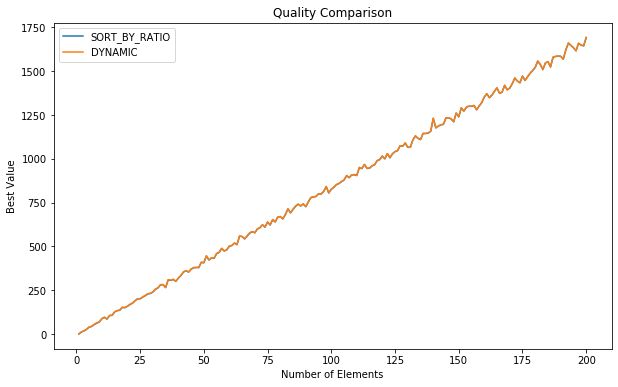

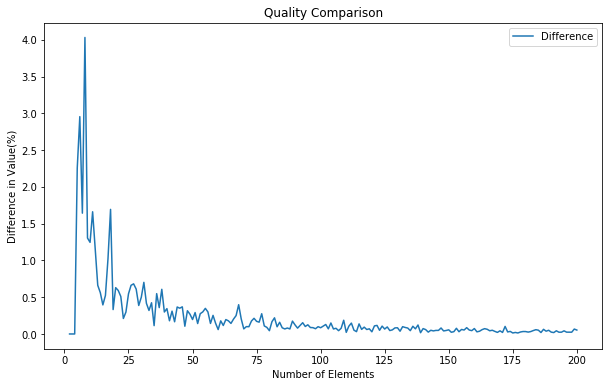

In [13]:
perform_tests_score([SORT_BY_RATIO,DYNAMIC],1,201)

# Conclusions

In the first part of the experiment we could clearly see that bruteforce algorithm was the worst one. We expected it because its time complexity is O(2^n) its only advantage is that it always finds best solution and its memory complexity is O(n). The greedy algorithm turned out to be the fastest of all. Its time and memory complexities are complexities of the python sorted function. From the graph we can see that it looks like almost linear with some fluctuations, but it certainly is not exactly linear. Dynamic algorithm is between both of them. Its time and memory complexity is O(n*max_weight) and max_weight is on awerage sum of all weigths divided by 2. Each weight is on average 10 so sum of weights is 10n and half of that is 5n. So time and memory complexity is O(n^2) in our case. Memory complexity is a disadvantage of a dynamic algorithm.

In the second part we discovered a surprising fact. The more elements there are the closer are sollutions of greedy algorithm to the solutions of dynamic one. The error gets close to 0% in fact. However for not many elements there error rate is even 4-5%. So the greedy algorithm seems to worth using when this 4-5% of value in the backpack is cheaper than than the cost of computation. In really big probems it could be quite high, especially that it requires a lot of memory, which is preety expensive. However things that we are going to "pack" in our "knapsacks" could be worth more. If we were packing diamonds maybe even this almost 0% difference would be wroth calculating

In [37]:
def find_with_dynamic(ids, weights, values, max_weight):
    n=len(ids)
    DP = np.zeros((n+1,max_weight+1))
    for i in range(1,n+1):
        for l in range(1,max_weight+1):
            if l < weights[i-1]:
                DP[i][l] = DP[i-1][l]
            else:
                DP[i][l] = max(DP[i-1][l], DP[i-1][l-weights[i-1]]+values[i-1])
    chosen_ids = []
    smallest_i = n
    cur_l = max_weight
    while smallest_i > 0 and cur_l > 0 and DP[smallest_i][cur_l]>0:
        while DP[smallest_i-1][cur_l] == DP[smallest_i][cur_l]:
            smallest_i-=1
        chosen_ids.append(smallest_i-1)
        cur_l-=weights[smallest_i-1]
        smallest_i-=1
    return (DP[n][max_weight],chosen_ids)

In [49]:
values = [3, 2, 6, 2, 11, 32]
find_by_ratio([0,1,2,3,4,5], [5,3,1,5,2,14],values,10)

(19, [2, 4, 1])

In [50]:
find_with_dynamic([0,1,2,3,4,5], [5,3,1,5,2,14],values,10)

(20.0, [4, 2, 0])

In [65]:
values = [3,2,6,2,17,32]
while True:
    new = values.copy()
    new[randrange(0,6)] = randrange(1,40)
    new[randrange(0,6)] = randrange(1,40)
    result_ration = find_by_ratio([0,1,2,3,4,5], [5,3,1,5,2,14],new,10)
    result_dynamic = find_with_dynamic([0,1,2,3,4,5], [5,3,1,5,2,14],new,10)
    if ((result_ration[0]*1.45) <= result_dynamic[0]):
        print("ration"+str(result_dynamic[0]/result_ration[0]))
        print(new, result_ration, result_dynamic)

ration1.5365853658536586
[28, 18, 6, 2, 17, 32] (41, [4, 1, 2]) (63.0, [4, 1, 0])
ration1.488888888888889
[3, 22, 6, 28, 17, 32] (45, [4, 1, 2]) (67.0, [4, 3, 1])
ration1.5121951219512195
[3, 18, 6, 27, 17, 32] (41, [4, 1, 2]) (62.0, [4, 3, 1])
ration1.4528301886792452
[3, 30, 6, 30, 17, 32] (53, [1, 4, 2]) (77.0, [4, 3, 1])
ration1.55
[28, 17, 6, 2, 17, 32] (40, [4, 2, 1]) (62.0, [4, 1, 0])
ration1.45
[24, 17, 6, 2, 17, 32] (40, [4, 2, 1]) (58.0, [4, 1, 0])
ration1.5116279069767442
[28, 20, 6, 2, 17, 32] (43, [4, 1, 2]) (65.0, [4, 1, 0])
ration1.5
[3, 21, 6, 28, 17, 32] (44, [4, 1, 2]) (66.0, [4, 3, 1])
ration1.4615384615384615
[3, 16, 6, 24, 17, 32] (39, [4, 2, 1]) (57.0, [4, 3, 1])
ration1.5227272727272727
[29, 21, 6, 2, 17, 32] (44, [4, 1, 2]) (67.0, [4, 1, 0])
ration1.4545454545454546
[26, 21, 6, 2, 17, 32] (44, [4, 1, 2]) (64.0, [4, 1, 0])
ration1.4651162790697674
[26, 20, 6, 2, 17, 32] (43, [4, 1, 2]) (63.0, [4, 1, 0])
ration1.5121951219512195
[3, 18, 6, 27, 17, 32] (41, [4, 1, 

[3, 18, 6, 28, 17, 32] (41, [4, 1, 2]) (63.0, [4, 3, 1])
ration1.488888888888889
[28, 22, 6, 2, 17, 32] (45, [4, 1, 2]) (67.0, [4, 1, 0])
ration1.4565217391304348
[3, 23, 6, 27, 17, 32] (46, [4, 1, 2]) (67.0, [4, 3, 1])
ration1.4545454545454546
[26, 21, 6, 2, 17, 32] (44, [4, 1, 2]) (64.0, [4, 1, 0])
ration1.4666666666666666
[27, 22, 6, 2, 17, 32] (45, [4, 1, 2]) (66.0, [4, 1, 0])
ration1.5116279069767442
[3, 20, 6, 28, 17, 32] (43, [4, 1, 2]) (65.0, [4, 3, 1])
ration1.5333333333333334
[3, 22, 6, 30, 17, 32] (45, [4, 1, 2]) (69.0, [4, 3, 1])
ration1.4545454545454546
[26, 21, 6, 2, 17, 32] (44, [4, 1, 2]) (64.0, [4, 1, 0])
ration1.5128205128205128
[3, 16, 6, 26, 17, 32] (39, [4, 2, 1]) (59.0, [4, 3, 1])
ration1.4509803921568627
[29, 28, 6, 2, 17, 32] (51, [1, 4, 2]) (74.0, [4, 1, 0])
ration1.5116279069767442
[3, 20, 6, 28, 17, 32] (43, [4, 1, 2]) (65.0, [4, 3, 1])
ration1.475
[3, 17, 6, 25, 17, 32] (40, [4, 2, 1]) (59.0, [4, 3, 1])
ration1.4651162790697674
[3, 20, 6, 26, 17, 32] (43, [4

ration1.511111111111111
[29, 22, 6, 2, 17, 32] (45, [4, 1, 2]) (68.0, [4, 1, 0])
ration1.46
[29, 27, 6, 2, 17, 32] (50, [1, 4, 2]) (73.0, [4, 1, 0])
ration1.4565217391304348
[27, 23, 6, 2, 17, 32] (46, [4, 1, 2]) (67.0, [4, 1, 0])
ration1.4871794871794872
[3, 16, 6, 25, 17, 32] (39, [4, 2, 1]) (58.0, [4, 3, 1])
ration1.4782608695652173
[28, 23, 6, 2, 17, 32] (46, [4, 1, 2]) (68.0, [4, 1, 0])
ration1.4634146341463414
[25, 18, 6, 2, 17, 32] (41, [4, 1, 2]) (60.0, [4, 1, 0])
ration1.5121951219512195
[3, 18, 6, 27, 17, 32] (41, [4, 1, 2]) (62.0, [4, 3, 1])
ration1.5128205128205128
[3, 16, 6, 26, 17, 32] (39, [4, 2, 1]) (59.0, [4, 3, 1])
ration1.4791666666666667
[29, 25, 6, 2, 17, 32] (48, [4, 1, 2]) (71.0, [4, 1, 0])
ration1.4565217391304348
[27, 23, 6, 2, 17, 32] (46, [4, 1, 2]) (67.0, [4, 1, 0])
ration1.5128205128205128
[26, 16, 6, 2, 17, 32] (39, [4, 2, 1]) (59.0, [4, 1, 0])
ration1.5333333333333334
[3, 22, 6, 30, 17, 32] (45, [4, 1, 2]) (69.0, [4, 3, 1])
ration1.4509803921568627
[29, 2

KeyboardInterrupt: 

In [ ]:
ration1.5714285714285714
[3, 19, 6, 30, 17, 32] (42, [4, 1, 2]) (66.0, [4, 3, 1])